# This cat does not exist
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ITMO][ML][MS][HW06] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

Цель этого задания - создать котов, которых не существует. В ходе данного задания вы обучите DCGAN и VAE, которые являются одними из первых генеративных моделей. Для этого задания вам наверняка потребуется GPU с CUDA, поэтому рекомендуется использовать Google Colab.

In [24]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os 
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import numpy as np

%matplotlib inline

In [25]:
def random_noise(batch_size, channels, side_size):
    return torch.randn(batch_size, channels, side_size, side_size).cuda()

def imagewide_average(x):
    return x.mean(dim=(-1, -2))

In [26]:
def visualise(imgs, rows=2):
    imgs = (imgs.transpose(1, 3) + 1) / 2
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = (torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1]
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [27]:
class CatDataset(Dataset):
    def __init__(self, path_to_dataset="cat_136", size=64):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
        self.size = size
    
    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path) # 136 x 136
        crop_rate = 8
        x_crop = random.randint(0, crop_rate)
        y_crop = random.randint(0, crop_rate)
        img = img[x_crop:136 - crop_rate + x_crop, y_crop:136 - crop_rate + y_crop]
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        return 2 * torch.tensor(img).float().transpose(0, 2) / 255. - 1
    
    def __len__(self):
        return len(self.photo_names)

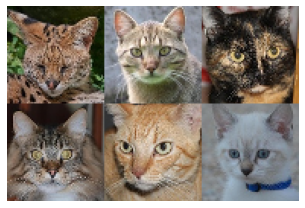

In [28]:
dataset = CatDataset()
visualise(torch.cat([dataset[i].unsqueeze(0) for i in [3, 15, 182, 592, 394, 2941]], dim=0))

### Задание 1 (2 балла)
Для начала реализуем генератор для нашего DCGAN. Предлагается использовать следующую архитектуру:

![](imgs/DCGAN.png)

Для ее реализации вам потребуются модули `nn.BatchNorm2d`, `nn.Conv2d`, `nn.ConvTranspose2D`, `nn.ReLU`, а также функция `F.interpolate`.

#### Методы
* `__init__` - принимает на вход `start_size`, `latent_channels`, `start_channels` и `upsamplings`. Первые два аргумента отвечают за размер случайного шума, из которого в последствии будет сгенерирована картинка. `start_channels` отвечает за то, сколько каналов должно быть в картинке перед тем, как к ней будут применены upsampling блоки. `upsamplings` - это количество upsampling блоков, которые должны быть применены к картинке. В каждом таком локе количество каналов уменьшается в два раза.


* `forward` - принимает на вход `batch_size`, генерирует `batch_size` картинок из случайного шума.

In [29]:
class Generator(nn.Module):
    def __init__(self, start_size=2, latent_channels=32, start_channels=1024, upsamplings=6):
        super().__init__()
        self.start_size = start_size
        self.latent_channels = latent_channels
        self.start_channels = start_channels
        self.upsamplings = upsamplings

        self.layer1 = nn.Conv2d(self.latent_channels, self.start_channels,\
                                kernel_size=1, stride=1, padding=0)
        self.upsampling_layer = nn.Sequential(
            nn.ConvTranspose2d(self.latent_channels, self.latent_channels // 2,\
                               kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(self.latent_channels // 2),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(self.latent_channels, 3,\
                                kernel_size=1, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, batch_size: int):
        input = torch.randn(batch_size, self.latent_channels, 1, 1)
        out = self.layer1(input)
        for _ in range(self.upsamplings):
            out = self.upsampling_layer(out)
            self.latent_channels /= 2
        out = self.layer2(out)
        return out


### Задание 2 (2 балла)
Для начала реализуем дискриминатор для нашего DCGAN. Предлагается использовать следующую архитектуру:

![](imgs/Disc_DCGAN.png)

Для ее реализации вам потребуются модули `nn.BatchNorm2d`, `nn.Conv2d`, `nn.ReLU` и `nn.Sigmoid`.

#### Методы
* `__init__` - принимает на вход `start_channels` и `downsamplings`. `start_channels` определяет количество каналов, которые должны быть в изображении перед применением downsampling блоков.


* `forward` - принимает на вход `x` - тензор с картинками. Возвращает вектор с размерностью `batch_size`.

In [1]:
class Discriminator(nn.Module):
    def __init__(self, downsamplings=6, start_channels=8):
        super().__init__()
        # self.image_size = image_size
        self.downsamplings = downsamplings
        self.start_channels = start_channels

        self.layer1 = nn.Conv2d(3, self.start_channels, kernel_size=1, stride=1, padding=0)
        self.downsampling_layer = nn.Sequential(
            nn.Conv2d(self.start_channels, self.start_channels * 2,  kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.start_channels * 2),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(nn.Linear(self.start_channels, 1), nn.Sigmoid())


    def forward(self, x):
        out = self.layer1(x)
        for _ in range(self.downsamplings):
            out = self.downsampling_layer(out)
            self.start_channels *= 2
        out = torch.flatten(out, start_dim=1)
        out = self.layer2(out)
        return out


NameError: name 'nn' is not defined

In [35]:
def train_gan():
    generator = Generator()
    discriminator = Discriminator()
    epochs = 2    # 120
    visualise_every = 1    # 10
    batch_size = 2    # 8
    generator.cuda()
    discriminator.cuda()

    gen_optim = Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    disc_optim = Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    dataset = CatDataset(size=128)

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size, )
        total_batches = 0
        gen_loss_avg = 0
        disc_loss_avg = 0

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            # Positive update
            batch = batch.cuda()
            pred = discriminator(batch)
            loss = F.bce_loss(pred, torch.ones_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Negative update
            batch = generator(batch_size).detach()
            pred = discriminator(batch)
            loss = F.bce_loss(pred, torch.zeros_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Generator update
            batch = generator(batch_size)
            pred = discriminator(batch)
            loss = F.bce_loss(pred, torch.ones_like(pred))
            gen_optim.zero_grad()
            loss.backward()
            gen_optim.step()
            gen_loss_avg += loss.item()
            
            if (ep + 1) % visualise_every == 0:
                with torch.no_grad():
                    visualise(generator(6), rows=2)

        print(f"Epoch {ep+1} | Discriminator loss: {disc_loss_avg / total_batches} | Generator loss: {gen_loss_avg / total_batches}")

In [36]:
train_gan()

AssertionError: Torch not compiled with CUDA enabled

### Задание 3 (5 баллов)
Теперь посмотрим на другую модель: Variational Autoencoder. В отличии от GAN, в котором генератор пытается себя обмануть дискриминатор, а дискриминатор старается не быть обманутым, VAE решает задачу реконструкции элемента множества X с применением регуляризации в латентном пространстве. 

Полностью архитектура выглядит так:
![](imgs/VAE.png)



В данном задании вам необходимо реализовать полную архитектуру VAE.

#### Методы
* `__init__` - принимает на вход `img_size`, `downsamplings`, `latent_size`, `linear_hidden_size`, `down_channels` и `up_channels`. `img_size` - размер стороны входного изображения. `downsamplings` - количество downsampling (и upsampling) блоков. `latent_size` - размер латентного пространства, в котором в который будет закодирована картинка. `linear_hidden_size` количество нейронов на скрытом слое полносвязной сети в конце encoder'а. Для полносвязной сети decoder'а это число стоит умножить на 2. `down_channels` - количество каналов, в которое будет преобразовано трехцветное изображение перед применением `downsampling` блоков. `up_channels` - количество каналов, которое должно получиться после применения всех upsampling блоков.

* `forward` - принимает на вход `x`. Считает распределение $N(\mu, \sigma^2)$ и вектор $z \sim N(\mu, \sigma^2)$. Возвращает $x'$ - восстановленную из вектора $z$ картинку и $D_{KL}(N(\mu, \sigma^2), N(0, 1)) = 0.5 \cdot (\sigma^2 + \mu^2 - \log \sigma^2 - 1)$.

* `encode` - принимает на вход `x`. Возвращает вектор из распределения $N(\mu, \sigma^2)$.

* `decode` - принимает на вход `z`. Возвращает восстановленную по вектору картинку.


#### Если хочется улучшить качество
https://arxiv.org/pdf/1906.00446.pdf

In [ ]:
class VAE(nn.Module):
    def __init__(self, img_size=128, downsamplings=5, latent_size=512, linear_hidden_size=1024, down_channels=8, up_channels=16):
        super().__init__()
        self.encoder = None
        self.decoder = None
        
    def forward(self, x):
        return x_pred, kld
    
    def encode(self, x):
        return z
    
    def decode(self, z):
        return x_pred

In [ ]:
def train_vae():
    vae = VAE()
    vae.cuda()

    epochs = 201
    batch_size = 8
    vae_optim = Adam(vae.parameters(), lr=1e-4)

    dataset = CatDataset(size=128)

    test_imgs_1 = torch.cat([dataset[i].unsqueeze(0) for i in (0, 34, 76, 1509)])
    test_imgs_2 = torch.cat([dataset[i].unsqueeze(0) for i in (734, 123, 512, 3634)])

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
        total_batches = 0
        rec_loss_avg = 0
        kld_loss_avg = 0

        if ep % 10 == 0:
            with torch.no_grad():
                z_1 = vae.encode(test_imgs_1.cuda())
                z_2 = vae.encode(test_imgs_2.cuda())
                x_int = []
                for i in range(9):
                    z = (i * z_1 + (8 - i) * z_2) / 8
                    x_int.append(vae.decode(z))
                x_int = torch.cat(x_int)
                visualise(x_int, rows=len(test_imgs_1))
                z_rand = torch.randn_like(z_1)
                x_int = vae.decode(z_rand)
                visualise(x_int, rows=len(test_imgs_1)//2)

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            x = batch.cuda()
            x_rec, kld = vae(x)
            img_elems = float(np.prod(list(batch.size())))
            kld_loss = kld.sum() / batch_size
            rec_loss = ((x_rec - x)**2).sum() / batch_size
            loss = rec_loss + 0.1 * kld_loss # https://openreview.net/forum?id=Sy2fzU9gl
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            kld_loss_avg += kld_loss.item()
            rec_loss_avg += rec_loss.item()

        print(f"Epoch {ep+1} | Reconstruction loss: {rec_loss_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")

train_vae()
